# Heart disease prediction
Dataset from: https://archive.ics.uci.edu/dataset/45/heart+disease
Task: binary prediction (cardiovascular disease diagnosis) based on 13 clinical features

In [1]:
import pandas as pd
from ucimlrepo import fetch_ucirepo
from collections import Counter
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import *
from mlflow import *
import mlflow
from mlflow.models import infer_signature
import os

In [2]:
# setting up mlflow experiment
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("Heart disease Diagnosis Prediction")

2025/04/28 20:44:39 INFO mlflow.tracking.fluent: Experiment with name 'Heart disease Diagnosis Prediction' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/876853252508933202', creation_time=1745865879471, experiment_id='876853252508933202', last_update_time=1745865879471, lifecycle_stage='active', name='Heart disease Diagnosis Prediction', tags={}>

## 1 - Loading the dataset

Diagnosis of heart disease (angiographic disease status)
        -- Value 0: < 50% diameter narrowing
        -- Value 1: > 50% diameter narrowing


In [3]:
# fetch dataset
heart_disease = fetch_ucirepo(id=45)

# data (as pandas dataframes)
X = heart_disease.data.features
y = heart_disease.data.targets

In [4]:
y_bin = [x>=1 for x in y['num'].tolist()]

print(y['num'].value_counts())
print(Counter(y_bin))

num
0    164
1     55
2     36
3     35
4     13
Name: count, dtype: int64
Counter({False: 164, True: 139})


In [5]:
df = pd.DataFrame(X, columns=X.columns)
df['Class'] = y_bin

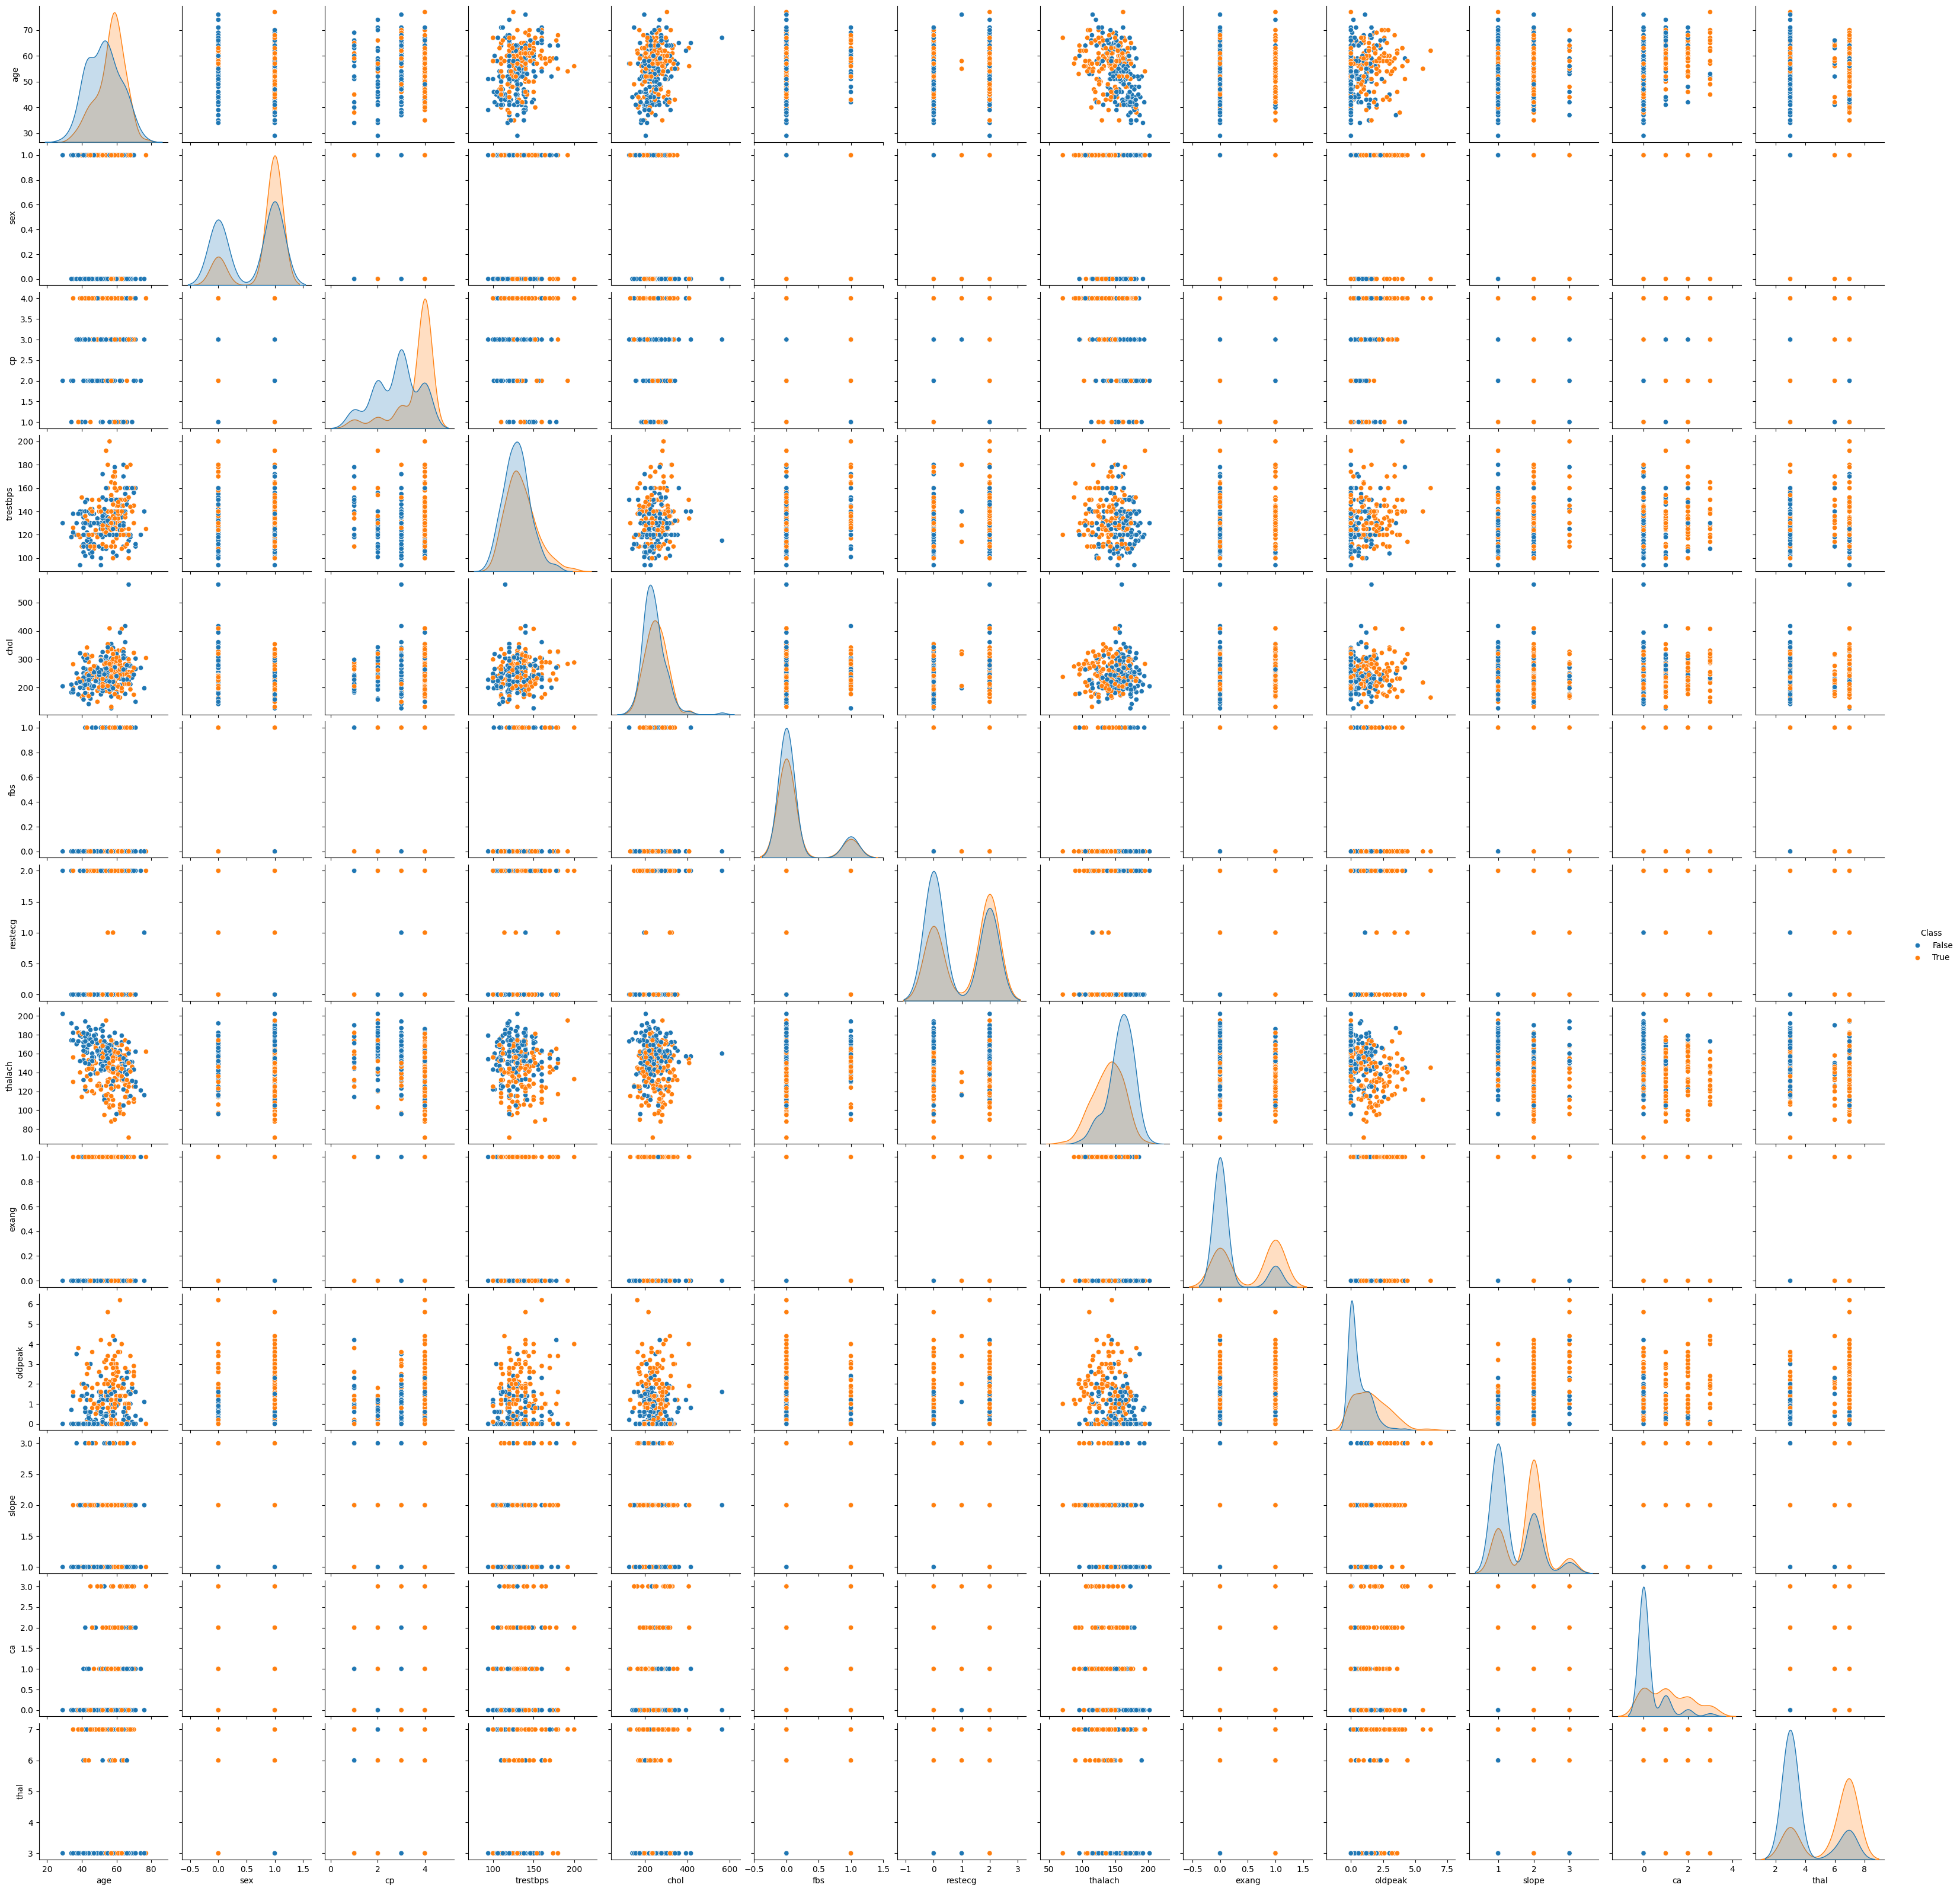

In [8]:

sns.pairplot(df, hue="Class")

## 2. Training and testing

In [6]:
# training test splitting
X_train, X_test, y_train, y_test = train_test_split(X,
                                     y_bin, stratify=y_bin, test_size=0.3, random_state=2)
path_art = os.getcwd()+"/artifacts/"
# Start an MLflow run
with mlflow.start_run():
    params = {'criterion':'gini', 'max_depth':7}
    mlflow.log_params(params)
    mlflow.set_tag("model_type", "DecisionTree")
    # training a simple decision tree
    clf = DecisionTreeClassifier(**params)
    clf.fit(X_train, y_train)
    
    # testing
    y_pred = clf.predict(X_test)
    mlflow.log_metric("f1_score", f1_score(y_test, y_pred))
    mlflow.log_metric("brier_score", brier_score_loss(y_test, clf.predict_proba(X_test)[:, 1]))
    

🏃 View run omniscient-koi-233 at: http://127.0.0.1:5000/#/experiments/876853252508933202/runs/7a100db8177b4a90ab41e6edded453c1
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/876853252508933202


## 3- Saving the best model in the MLFlow Model Registry

In [7]:
signature = infer_signature(X_test, y_pred)
signature

/Users/giovannanicora/anaconda3/envs/redcap-formrec-env/lib/python3.11/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


inputs: 
  ['age': long (required), 'sex': long (required), 'cp': long (required), 'trestbps': long (required), 'chol': long (required), 'fbs': long (required), 'restecg': long (required), 'thalach': long (required), 'exang': long (required), 'oldpeak': double (required), 'slope': long (required), 'ca': double (optional), 'thal': double (optional)]
outputs: 
  [Tensor('bool', (-1,))]
params: 
  None

In [8]:
# Log the sklearn model and register as version 1
mlflow.sklearn.log_model(
        sk_model=clf,
        artifact_path="sklearn-model",
        signature=signature,
        registered_model_name="heart-disease-decision-tree-model",
    )

Successfully registered model 'heart-disease-decision-tree-model'.
2025/04/28 20:45:48 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: heart-disease-decision-tree-model, version 1
Created version '1' of model 'heart-disease-decision-tree-model'.
